# MARCO 

Crystallizing molecular targets of interest remains the bottleneck of the entire crystallography program in structural biology. So there was a need of an algorithm that could analyze images of drops, distinguish crystals from trivial outcomes, and reduce the effort spent cataloging failure, would present clear value both to the discipline and to industry. This notebook tries to address the problem of classifying crystilization outcome images accross 4 classes, i.e., Clear, Crystal, Precipitate or Other.

# 1.0 Import Required libraries

In [1]:
import sys
sys.path.append('/home/kavan33_gmail_com/anaconda3/lib/python3.5/site-packages')

In [2]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import numpy as np
import PIL
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
import copy
from utils import MarcoDataloader
from torch import nn

In [3]:
train_info = pd.read_csv("/home/kavan33_gmail_com/BATCH/info.csv",index_col=0)

In [4]:
val_info = pd.read_csv("/home/kavan33_gmail_com/BATCH_Test/info.csv",index_col=0)

In [5]:
train_info.groupby(['label_id','label_text']).size().reset_index()

,label_id,label_text,0
0,0,Clear,329
1,1,Crystals,121
2,2,Other,62
3,3,Precipitate,512


In [6]:
test_info = val_info.iloc[int(len(val_info)/2):]
validation_info = val_info.iloc[:int(len(val_info)/2)]

In [8]:
##############################################################################################
#validation_info.to_csv("/home/kavan33_gmail_com/BATCH_Test/info.csv") # Call once!!!!!!!!    #
#test_info.to_csv("/home/kavan33_gmail_com/BATCH_Test/test_info.csv") #Call once!!!!!!!!!!!!  #
##############################################################################################

In [7]:
train_path = "/home/kavan33_gmail_com/BATCH"

In [8]:
val_path = "/home/kavan33_gmail_com/BATCH_Test/"

In [61]:
test_path = "/home/kavan33_gmail_com/TestData/Test/"

In [9]:
train_info = train_info.reset_index()

In [10]:
val_info = val_info.reset_index()

In [11]:
train_info.head()

,image_path,image_id,label_id,label_text,label_raw,source
0,/home/kavan33_gmail_com/BATCH/Clear/396612.jpeg,396612,0,Clear,1,2
1,/home/kavan33_gmail_com/BATCH/Precipitate/2866...,286612,3,Precipitate,14,3
2,/home/kavan33_gmail_com/BATCH/Precipitate/4217...,421709,3,Precipitate,30,2
3,/home/kavan33_gmail_com/BATCH/Clear/90089.jpeg,90089,0,Clear,2,3
4,/home/kavan33_gmail_com/BATCH/Precipitate/2961...,296118,3,Precipitate,14,3


In [12]:
val_info.head()

,image_path,image_id,label_id,label_text,label_raw,source
0,/home/kavan33_gmail_com/BATCH_Test/Clear/84080...,84080,0,Clear,2,3
1,/home/kavan33_gmail_com/BATCH_Test/Precipitate...,327605,3,Precipitate,16,3
2,/home/kavan33_gmail_com/BATCH_Test/Clear/36632...,366321,0,Clear,2,3
3,/home/kavan33_gmail_com/BATCH_Test/Clear/77600...,77600,0,Clear,9,1
4,/home/kavan33_gmail_com/BATCH_Test/Precipitate...,155413,3,Precipitate,16,3


# 2.0 EDA

## 2.1 Train Data

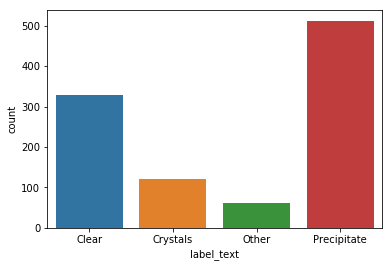

In [13]:
label_count = pd.DataFrame(train_info.groupby(['label_text'])['label_text'].count())
label_count.columns = ['count']
label_count.reset_index(inplace=True)
sns.barplot(label_count['label_text'],label_count['count'])

## 2.2 Validation Data

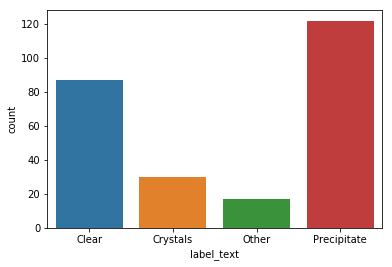

In [14]:
val_label_count = pd.DataFrame(validation_info.groupby(['label_text'])['label_text'].count())
val_label_count.columns = ['count']
val_label_count.reset_index(inplace=True)
sns.barplot(val_label_count['label_text'],val_label_count['count'])

## 2.3 Test Data

In [15]:
test_label_count = pd.DataFrame(test_info.groupby(['label_text'])['label_text'].count())

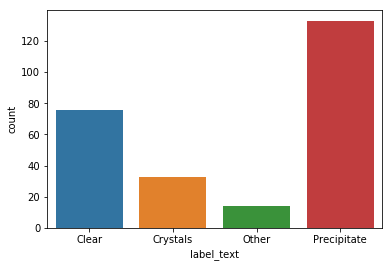

In [16]:
test_label_count.columns = ['count']
test_label_count.reset_index(inplace = True)
sns.barplot(test_label_count['label_text'],test_label_count['count'])

## 2.4 t-SNE plot

Lets try to have a t-SNE plot so that we can get a general idea about the images, and get an idea if images can be grouped as a cluster

In [33]:
from sklearn.manifold import TSNE
import cv2

In [34]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [67]:
X = []
label =[]
for i in range(len(train_info)):
    row = train_info.iloc[i]
    img = row['image_path']
    lab = row['label_id']
    img = cv2.imread(img)
    img.resize(224,224)
    img = img.flatten()
    X.append(img)
    label.append(lab)

In [68]:
tr = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1024 samples in 1.753s...
[t-SNE] Computed neighbors for 1024 samples in 81.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 843.578909
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.410404
[t-SNE] Error after 300 iterations: 0.633221


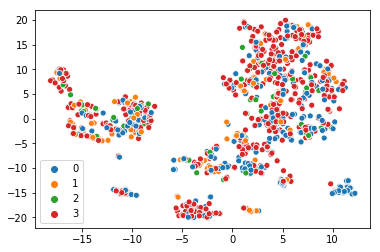

In [69]:
x = tr[:,0]
y = tr[:,1]
a = sns.scatterplot(x,y,hue=label,palette=sns.color_palette()[:4])

Looks like there is not much of information that can be derived from a dimensional reduction process.

# 2.5 Display few images of each class

In [36]:
def display_image(label,info):
    print ("5 Images of label:",label," and Label-Text: ",train_info[train_info['label_id']==label]['label_text'].unique())
    for i in train_info[train_info['label_id']==label]['image_path'][:5]:
        im = Image.open(i)
        print ("Shape of below image",np.shape(im))
        display(im.resize((300,250)))

5 Images of label: 0  and Label-Text:  ['Clear']
Shape of below image (504, 632, 3)


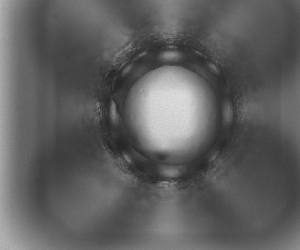

Shape of below image (960, 1280, 3)


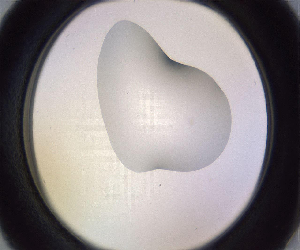

Shape of below image (960, 1280, 3)


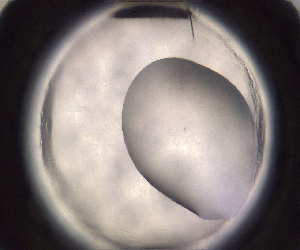

Shape of below image (960, 1280, 3)


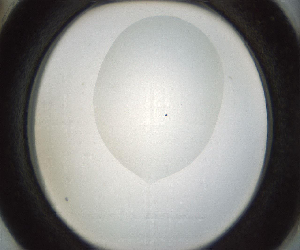

Shape of below image (960, 1280, 3)


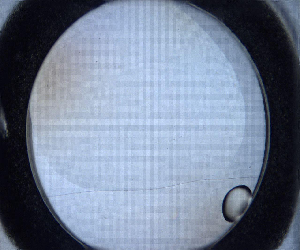

5 Images of label: 3  and Label-Text:  ['Precipitate']
Shape of below image (960, 1280, 3)


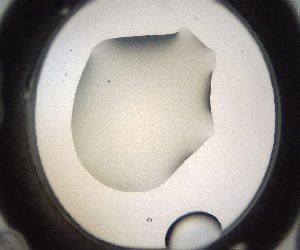

Shape of below image (504, 632, 3)


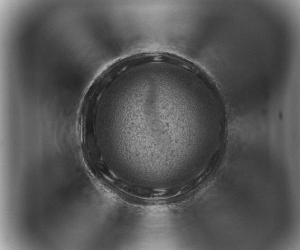

Shape of below image (960, 1280, 3)


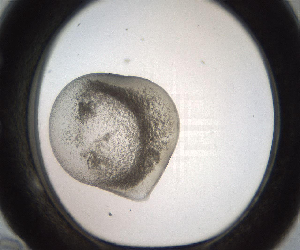

Shape of below image (960, 1280, 3)


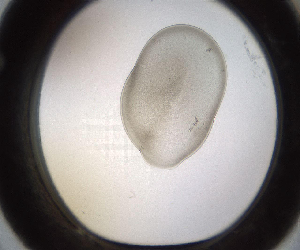

Shape of below image (504, 632, 3)


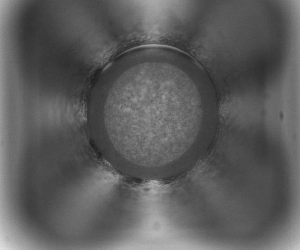

5 Images of label: 1  and Label-Text:  ['Crystals']
Shape of below image (960, 1280, 3)


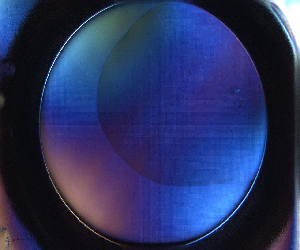

Shape of below image (960, 1280, 3)


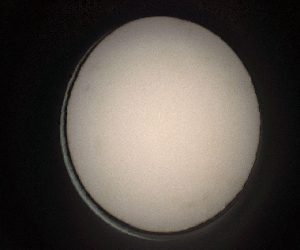

Shape of below image (960, 1280, 3)


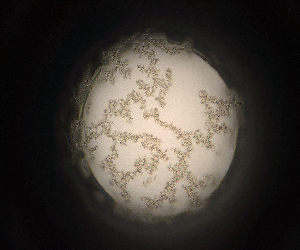

Shape of below image (960, 1280, 3)


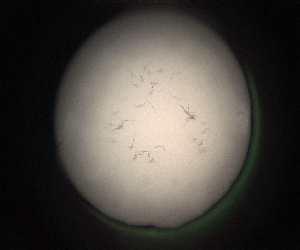

Shape of below image (960, 1280, 3)


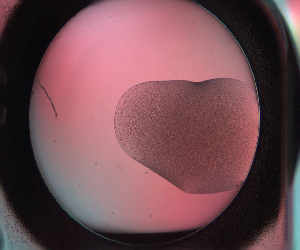

5 Images of label: 2  and Label-Text:  ['Other']
Shape of below image (504, 632, 3)


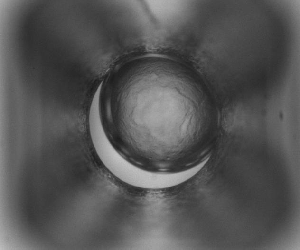

Shape of below image (960, 1280, 3)


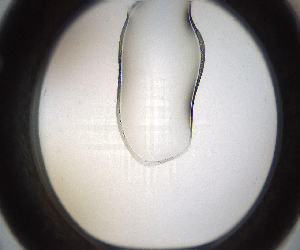

Shape of below image (960, 1280, 3)


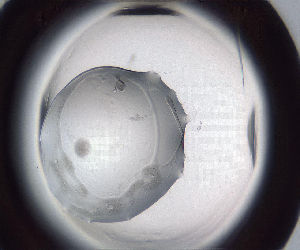

Shape of below image (960, 1280, 3)


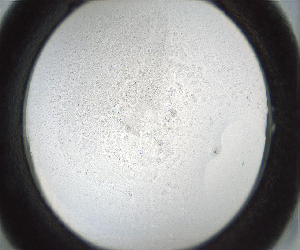

Shape of below image (960, 1280, 3)


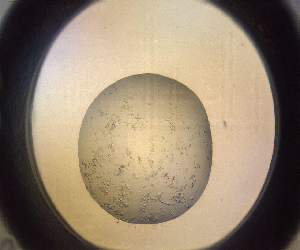

In [37]:
for i in train_info['label_id'].unique():
    display_image(i,train_info)

# 3.0 Pytorch Dataloader and Transformation

In [24]:
transformation = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=[0,270]),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val' : transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=[0,270]),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
}

In [62]:
transformation_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25),
    transforms.ToTensor(),
])

In [25]:
train_dataset = MarcoDataloader.MarcoDataset(train_path,transformation['train'])

In [26]:
val_dataset = MarcoDataloader.MarcoDataset(val_path,transformation['val'])

In [63]:
test_dataset = MarcoDataloader.MarcoDataset(test_path,transformation_test)

In [27]:
train_loader = DataLoader(dataset = train_dataset,batch_size=32, shuffle=True)

In [28]:
val_loader = DataLoader(dataset = val_dataset,batch_size=32, shuffle= True)

In [64]:
test_loader = DataLoader(dataset= test_dataset, batch_size=32, shuffle = True)

In [29]:
dataloader = {
    'train': train_loader, 'val' : val_loader
}

In [30]:
dataset_sizes = {
    'train':len(train_dataset), 'val': len(val_dataset)
}

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
device

device(type='cuda', index=0)

# 3.1 Visualize few images after transformation

In [47]:
img, lab = next(iter(train_loader))

In [66]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.5, 0.5, 0.5])
    #std = np.array([0.5, 0.5, 0.5])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(45,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontdict=dict(fontsize=36))
    plt.pause(0.001)

In [67]:
out = torchvision.utils.make_grid(img)

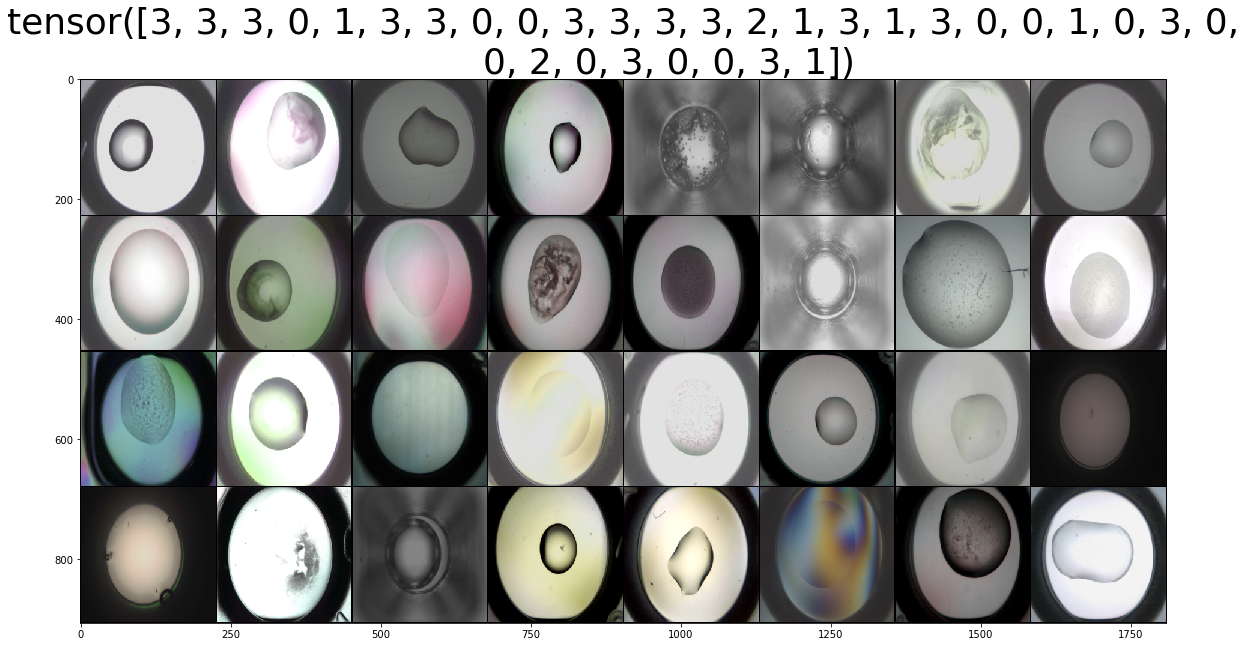

In [50]:
imshow(out,title = lab)

# 4.0 Building Predective model

## 4.1 Resnet50

In [17]:
import torchvision.models as models

In [18]:
r50 = models.resnet50(pretrained=True)

Freeze all layers

In [19]:
for params in r50.parameters():
    params.requires_grad = False

In [20]:
no_feautures = r50.fc.in_features

In [21]:
no_feautures

2048

In [22]:
r50.fc = nn.Linear(2048,4)

In [33]:
r50 = r50.to(device)

## 4.2 Model Training

In [34]:
performance_rmsprop = pd.DataFrame(columns=['phase','epoch','accuracy'])

In [35]:
performance_SGD = pd.DataFrame(columns=['phase','epoch','accuracy'])

In [36]:
#performance_rmsprop.loc[len(performance_rmsprop)] = [1,0.5]


In [37]:
from tqdm import tqdm

In [38]:
criterion = nn.CrossEntropyLoss()

In [39]:
optimizer_conv = optim.RMSprop(list(filter(lambda p: p.requires_grad, r50.parameters())))#, lr=0.01, momentum = 0.9)

In [40]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

In [41]:
def train_model(performance_rmsprop,model,criterion, optimizer, scheduler, num_epochs=10):
    
    #https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    for epoch in range(num_epochs):
        print ('Epoch{}/{}'.format(epoch,num_epochs - 1))
        print ('----------')
        
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0                
            for data in tqdm(dataloader[phase]):
                images, labels = data                
                images = images.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            performance_rmsprop.loc[len(performance_rmsprop)] = [phase,epoch,epoch_acc.data.cpu().numpy()]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [42]:
r50 = train_model(performance_rmsprop, model = r50, criterion = criterion, optimizer = optimizer_conv, scheduler = exp_lr_scheduler, num_epochs =10) 

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch0/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 18.4350 Acc: 0.4111


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 11.3789 Acc: 0.3574

Epoch1/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 5.1045 Acc: 0.5361


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.1283 Acc: 0.4023

Epoch2/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 4.6553 Acc: 0.5410


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.7934 Acc: 0.4141

Epoch3/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 3.8472 Acc: 0.5820


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 6.3225 Acc: 0.5488

Epoch4/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 3.3149 Acc: 0.5879


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 5.8254 Acc: 0.4121

Epoch5/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 1.4791 Acc: 0.6953


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.6428 Acc: 0.6504

Epoch6/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 1.1659 Acc: 0.7275


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.3394 Acc: 0.6895

Epoch7/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 1.1702 Acc: 0.7227


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.3857 Acc: 0.6816

Epoch8/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 1.1920 Acc: 0.7207


  0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.4024 Acc: 0.6758

Epoch9/9
----------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 1.0840 Acc: 0.7285


100%|██████████| 16/16 [01:34<00:00,  5.98s/it]

val Loss: 1.2417 Acc: 0.7324

Training complete in 47m 34s
Best val Acc: 0.732422


In [134]:
train_performance = performance_rmsprop[performance_rmsprop['phase']=='train']
val_performace = performance_rmsprop[performance_rmsprop['phase']=='val']
train_performance = train_performance.reset_index(drop = True)
val_performace = val_performace.reset_index(drop = True)

In [43]:
performance_rmsprop['dummy'] = 0

/home/kavan33_gmail_com/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


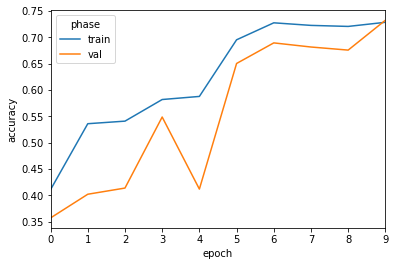

In [44]:
sns.tsplot(time = "epoch",value="accuracy",data = performance_rmsprop, unit = "dummy",condition="phase")

# Testing

Test on few batch

In [78]:
correct = 0
total = 0
i =0
with torch.no_grad():
    for data in test_loader:
        #print (i)
        i+=1
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = r50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i == 5:
            break
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

0
1
2
3
4
Accuracy of the network on the 10000 test images: 62 %
